# Theoretical Part

$\textbf{Hypothesis Testing – The problem of multiple comparisons [5 points]}$

Experimentation in AI often happens like this: 
Modify/Build an algorithm
Compare the algorithm to a baseline by running a hypothesis test.
If not significant, go back to step A
If significant, start writing a paper. 

Compute the probabilities below (with Type I error for each test = α):

a) P(mth experiment gives significant result | m experiments lacking power to reject H0)?

b) P(at least one significant result | m experiments lacking power to reject H0)?



$\textit{Answers:}$

a) Since the experiments are indipendent, meaning that the result of one does not depend on the result on the others, we can express the requested probability as the probability an experiment gives a significant result. So, this probability is equal to P(reject $H_0$ | $H_0$ true) = $\alpha$


b) An experiment is lacking the power to reject the null hypothesis with a probability $1 - \alpha$.
Since, as soon as we get a wrong result (i.e. we get a significant result) we stop to do experiment, the probability is:

\begin{align}
P(\text{ at least one significant result } | \text{ m experiments lacking power to reject } H_0) &= \sum_{i=1}^{m} P(i \text{ was wrong } \wedge \bigwedge_{j=1}^{i-1} j \text{ was right }) \\
&= \sum_{i=1}^{m} P(i \text{ was wrong}) \cdot \prod_{j=1}^{i-1} P(j \text{ was right }) \\
&= \sum_{i=1}^{m} \alpha \cdot \prod_{j=1}^{i-1} (1-\alpha) \\
&= \alpha \sum_{i=1}^{m} \prod_{j=1}^{i-1} (1-\alpha) \\
&= \alpha \sum_{i=1}^{m} (1 - \alpha)^{i-1} \\
&= \alpha \sum_{i=0}^{m-1} (1-\alpha)^{i} \\
&= \alpha \frac{1 - (1-\alpha)^{m}}{1 - (1-\alpha)} \\
&= \alpha \frac{1 - (1-\alpha)^{m}}{\alpha} \\
&= 1 - (1-\alpha)^{m} \\
\end{align}


Alternatively, the probability of having at least one significant result in $m$ experiments lacking the power to reject $H_0$ can be also seen as 1 minus the probability of correcly not refusing the null hypothesis for all the experiments. The latter is given by:

$\prod_{i=1}^m(1 - P(\text{ reject } H_0 \text{ at i }| H_0 \text{true}))$ = $(1 - \alpha)^{m}$

Hence the requested probability is the same as before:

P(at least one significant result | $m$ experiments lacking the power to reject $H_0$) = $ 1 - (1 - \alpha)^{m}$.

$\textbf{Bias and unfairness in Interleaving experiments [10 points]}$

Balance interleaving has been shown to be biased in a number of corner cases. An example was given during the lecture with two ranked lists of length 3 being interleaved, and a randomly clicking population of users that resulted in algorithm A winning ⅔ of the time, even though in theory the percentage of wins should be 50% for both algorithms. Can you come up with a situation of two ranked lists of length 3 and a distribution of clicks over them for which Team-draft interleaving is unfair to the better algorithm?


$\textit{Answer:}$

Let's consider the following 2 ranked list where the letters represents different documents:

L1: A, B, C
L2: D, B, A

At the first turn, whichever team wins the coin toss, the first document of both the two lists is chosen.
As a result the document A is also removed from the available documents in L2.
Then, the two lists will be:

L1: B, C
L2: B

Now, there are two cases:

1) the first team wins the coin toss:
	- B is chosen from L1 and removed from L2.
	- L2 is therefore empty
	- as a result, we have chosen {A, B} form L1 and {D} from L2

2) the second team wins the coin toss:
	- B is chosen from L2 and removed from L1
	- C is chosen from L1
	- finally, we have chosen {A, C} from L1 and {D, B} from L2

So, half of the times the assignment is unbiased (assigning 2 documents from each teams), while the other times 2 documents are taken from L1 and only 1 from L2. As a result, on average the assignment is biased toward L1.





# Experimental Part

In [1]:
from itertools import product
import math
import random
import numpy as np
from abc import ABCMeta, abstractmethod
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binom_test
from scipy.stats.stats import pearsonr
%matplotlib inline

$\textbf{Simulate Rankings of Relevance for E and P}$

In [2]:
relevance = ["N", "R", "HR"] # relevance labels
rel_to_num = {"N":0, "R": 1, "HR":2} # relevance values for nDCG
r2binary = {"R": 1, "HR": 1, "N": 0} # relevance values for precision

K = 5

### Simulate Rankings of Relevance for E and P

# k = length of the ranking
# returns: 2 list of simulate rankings of length k 
def create_rankings(k):
    
    possible_rankings = list(product(relevance, repeat=k*2)) # cartesian product to obtain all possible pairs of rankings
    random.shuffle(possible_rankings) # shuffle in case considering only first n pairs
    
    p = []
    e = []
    
    for ranking in possible_rankings:
        p.append(ranking[:k])
        e.append(ranking[k:])
        
    return p, e

In [3]:
p, e = create_rankings(K)
rand_ind = np.random.randint(len(p))
# draw an example of ranking pair
print("P: ", p[rand_ind])
print("E: ", e[rand_ind])

P:  ('R', 'N', 'N', 'N', 'N')
E:  ('HR', 'R', 'N', 'R', 'HR')


$\textbf{Implement Evaluation Measures}$

In [4]:
### Precision at rank k 

# ranking = list of ranked relevance labels
# rank = length of the list
def precision(ranking, rank=None):
    if rank is None:
        rank = len(ranking)
    
    tp = 0 #number or relevant documents retrieved
    for i in range(rank):
        tp += r2binary[ranking[i]] #add one for each relevant document
    return tp/rank #average on total number of documents retrieved

In [5]:
print(p[0])
print(precision(p[0], K))

('N', 'HR', 'HR', 'HR', 'N')
0.6


In [6]:
### Normalized Discounted Cumulative Gain at rank k (nDCG@k)

def DCG(ranking, rank):
    DCG = 0
    for i in range(rank):
        DCG += (math.pow(2, rel_to_num[ranking[i]]) - 1)/(math.log(1 + (i+1), 2)) 
    return DCG

### calculate  and save normalizing constants for all ranks
# since we are considering all possible combinations of rankings, we assume there are at least 5 documents labeled as
# 'HR', hence the best possible ranking used to normalize the DCG measure is [HR, HR, HR, HR, HR] for k = 5.
normalizing_constants = []
for i in range(1, 6):
    normalizing_constants.append(DCG(['HR'] * i, i))# calculate DCG for best possible ranking
    

def nDCG(ranking, rank):
    #divide DCG by normalizing constant appropriate to considerate rank
    return DCG(ranking, rank) / normalizing_constants[rank - 1]


In [7]:
print(p[0])
print(nDCG(p[0],K))

('N', 'HR', 'HR', 'HR', 'N')
0.5296347172140421


In [8]:
### Expected Reciprocal Rank

def ERR(ranking, rank):
    prob = 1 #initial stop probability
    ERR = 0
    
    #function to calculate the probability of satistaction
    def probability(r):
        tmp = np.power(2, r)
        return (tmp - 1) / np.max(tmp)
    
    ranking = np.array([rel_to_num[ranking[i]] for i in range(rank)]) #convert from labels to relevance
    
    R = probability(ranking)
    
    for r in range(rank):
        ERR += (prob * R[r]) / (r+1)  
        prob *= 1 - R[r]  #update stop probability
    
    return ERR

In [9]:
print(ERR(p[0],K))
print(p[0])

0.44921875
('N', 'HR', 'HR', 'HR', 'N')


$\textbf{Calculate the 𝛥measure}$

In [10]:
### Compare the rankings from Production and the ranking from Experimental with a given measure.


# p: ranking from Production
# e: ranking from Experimental
# k: maximum rank
# measure: evaluation measure to use
# returns: array of differences between measures
def compare(p, e, k, measure):
    
    assert len(p) == len(e)
    assert k > 0
    
    results = []
    
    for r in range(len(p)):
        m_e = measure(e[r], k)
        m_p = measure(p[r], k)

        results.append(m_e - m_p)
    
    return results

# returns: percentage of time E wins for every measure
def compute(k, rankings=None):
    if rankings is None:
        p, e = create_rankings(k)
    else:
        p, e = rankings

    assert len(p) == len(e)
    assert k > 0

    measures = {'precision': precision, 'nDCG': nDCG, 'ERR': ERR}
    results = {}
    ties = {}

    for name, measure in measures.items():
        res = compare(p, e, k, measure)
        results[name] = 0
        ties[name] = 0
        for result in res:
            if result > 0:
                results[name] += 1  # add one every time the difference is bigger than 0
            if result == 0:
                ties[name] += 1
        results[name] /= len(res)
        ties[name] /= len(res)

    return results, ties

# compare the performances of the two sorting algorithms p and e given a certain measure and rank k, return the subset of the data in which e outperforms p
def biased_dataset(p, e, k, measure):
    res = compare(p, e, k, measure)
    b_p = []
    b_e = []
    for i in range(len(res)):
        if res[i] > 0:
            b_p.append(p[i])
            b_e.append(e[i])
    return b_p, b_e
        
    

In [11]:
measures = {'precision': precision, 'nDCG': nDCG, 'ERR': ERR}
prec_p, prec_e = biased_dataset(p, e, K, measures['precision'])
ndcg_p, ndcg_e = biased_dataset(p, e, K, measures['nDCG'])
err_p, err_e = biased_dataset(p, e, K, measures['ERR'])
biased_datasets = {'precision': (prec_p, prec_e), 'nDCG': (ndcg_p, ndcg_e), 'ERR': (err_p, err_e)}

In [12]:
percent_of_wins, percent_of_ties = compute(K)
percent_of_wins_and_ties = {'precision': percent_of_wins['precision'] + 1/2 * percent_of_ties['precision'] ,
                             'nDCG': percent_of_wins['nDCG'] + 1/2 *  percent_of_ties['nDCG'],
                             'ERR':  percent_of_wins['ERR'] + 1/2 *  percent_of_ties['ERR']}

print("Percentage of Wins:", percent_of_wins, "\n")
print("Percentage of Ties:", percent_of_ties, "\n")
print("Percentage of Wins + 1/2 of Ties:", percent_of_wins_and_ties, "  (should be 0.5)\n")

Percentage of Wins: {'ERR': 0.49745126928483124, 'nDCG': 0.4974851394604481, 'precision': 0.3685413808870599} 

Percentage of Ties: {'ERR': 0.005097461430337517, 'nDCG': 0.005029721079103796, 'precision': 0.2629172382258802} 

Percentage of Wins + 1/2 of Ties: {'ERR': 0.5, 'nDCG': 0.5, 'precision': 0.5}   (should be 0.5)



$\textbf{Implement Interleaving }$

In [13]:
### Team Draft Interleaving
# rankingA, rankingB: list of ranked documents for P and E
# returns: list of interleaved documents, list containing team assignments

def teamDraftInterleaving(rankingA, rankingB):
    interleaved_list = []
    team_assignment = []

    ranking = [rankingA, rankingB]
    count = [0, 0]
    
    while count[0] < len(ranking[0]) and count[1] < len(ranking[1]):
        #while both rankings can provide at least one document
        #take document from the team that provided less so far
        #or toss a coin if tie
        assignment = 1 - int(count[0] < count[1] or (count[0] == count[1] and np.random.rand() > 0.5))
        
        team_assignment.append(assignment) # 0 = team A, 1 = team B
        interleaved_list.append(ranking[assignment][count[assignment]])
        count[assignment] += 1
    
    return interleaved_list, team_assignment


### Probabilistic Interleaving

def probabilisticInterleaving(rankingA, rankingB):
    # COIN = 0 for rankingA,  COIN = 1 for rankingB
    k = len(rankingA)  # rank

    interleaved_list = []  # final list of merged documents
    team_assignment = []  # from which ordering does a document come
    used = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]  # mark already inserted documents
    
    pdoc = []  # probability distributions of documents
    tau = 3
    
    
    ### check if document was already inserted into the merged list
    def is_used(n, used):
        i = 0
        while n > pdoc[i]:
            i += 1
        return -1 if used[i] else i
    
    
    ### take a document from the ordering chose by the coin flip following the distribution probab. in that ordering
    def get_doc(used):
        rand = random.uniform(0, 1)
        idx = is_used(rand, used)
        while idx == -1:
            rand = random.uniform(0, 1)
            idx = is_used(rand, used)
        return idx
    
    
    ### create distributions of documents based on ranking
    for i in range(k):
        pdoc.append(pdoc[-1] + 1 / np.power(i + 1, tau) if len(pdoc) > 0 else 1 / np.power(i + 1, tau))
    pdoc /= pdoc[-1]

    
    ### toss coins and add a document to the new list
    for i in range(k * 2):
        
        if used[0].count(1) == k:
            coin = 1
        elif used[1].count(1) == k:
            coin = 0
        else:
            coin = random.randint(0, 1)
        
        idx = get_doc(used[coin])
        if coin:
            interleaved_list.append(rankingB[idx])
        else:
            interleaved_list.append(rankingA[idx])
        
        used[coin][idx] = 1
        team_assignment.append(coin)
        
    return interleaved_list, team_assignment

### returns a pair representing the credits for the two team_assignment given 
### an interleaved list of documents with the relative team assignments and the position of clicks
def computeCredit(interleaved_list, team_assignment, clicks):
    assert len(interleaved_list) == len(clicks)
    assert len(interleaved_list) == len(team_assignment)

    credits = 0, 0

    for team, n_clicks in zip(team_assignment, clicks):
        credits[team] += n_clicks

    return credits


interleaved_list, team_assignment = teamDraftInterleaving(p[0], e[0])

In [14]:
print('P: ', p[0])
print('E: ', e[0])
print('Interleaved list: ', interleaved_list)
print('Team assignments: ', team_assignment)

P:  ('N', 'HR', 'HR', 'HR', 'N')
E:  ('R', 'HR', 'HR', 'HR', 'HR')
Interleaved list:  ['N', 'R', 'HR', 'HR', 'HR', 'HR', 'HR', 'HR', 'HR']
Team assignments:  [0, 1, 0, 1, 1, 0, 1, 0, 1]


$\textbf{Implement User Clicks Simulation}$

In [15]:
# Abstract Click Model Class
class UserClickModel:
    __metaclass__ = ABCMeta

    @abstractmethod
    def train(self, trainingset):
        pass

    @abstractmethod
    def probabilities(self, ranking):
        pass

    def click(self, probabilities):
        return np.random.binomial(n=1, p=probabilities)
    
    @abstractmethod
    def parse(self, filename):
        pass


# Random Click Model
class RandomClickModel(UserClickModel):

    def __init__(self):
        self.p = 0 #click probability
    
    def train(self, trainingset):
        click_count, total_count = self.parse(trainingset) 
        #estimate probability with average number of click per document
        self.p = click_count/total_count
    
    def probabilities(self, ranking):
        #assign same probability to all documents
        return self.p * np.ones(len(ranking))

    def parse(self, filename):
        """
        Parses search sessions, formatted according to the Yandex Relevance Prediction Challenge (RPC)
        (http://imat-relpred.yandex.ru/en/datasets).
        Returns a list of SearchSession objects.
        An RPC file contains lines of two formats:
        1. Query action
        SessionID TimePassed TypeOfAction QueryID RegionID ListOfURLs
        2. Click action
        SessionID TimePassed TypeOfAction URLID
        
        :param filename: The name of the file with search sessions formatted according to RPC.
        :returns: total count
        """
    
        file = open(filename, "r")
        
        click_count = 0
        total_count = 0
        
        for line in file:
        
            entry_array = line.strip().split("\t")
        
            # If the entry has 6 or more elements it is a query
            if len(entry_array) >= 6 and entry_array[2] == "Q":
                task = entry_array[0]
                docs = set(entry_array[5:])
                total_count += len(docs)
                
            # If the entry has 4 elements it is a click
            elif len(entry_array) == 4 and entry_array[2] == "C":
                doc = entry_array[3]
            
                if entry_array[0] == task and doc in docs:
                    click_count += 1
        
            # Else it is an unknown data format so leave it out
            else:
                continue
    
        return click_count, total_count


# Position-Based Model
class PositionBasedModel(UserClickModel):

    def __init__(self):
        self.gammas = []
        self.alphadict = {"N": 0.05, "R": 0.5, "HR": 0.95} # not trained attractivnesses, values from table 8.1 
        # in the book
    
    def train(self, trainingset):
        documents, ranking = self.parse(trainingset)

        # alphas and gammas are initialised to 0.2, as suggested in the book

        alphas = {} #attractivness, dictionary with key = (document_id, query)
        self.gammas = [0.2] * 10 

        for document_id, document in documents.items():
            for query in document.keys():
                alphas[(document_id, query)] = 0.2


        epochs = 10 #number of iterations for the EM algorithm


        for epoch in range(epochs):
            ### estimating alphas
            for document_id, document in documents.items():
                for query, occurrencies in document.items():
                    update_alpha = 0

                    for rank_click in occurrencies:
                        rank = rank_click[0]
                        click = rank_click[1]
                        alpha = alphas[(document_id, query)]
                        gamma = self.gammas[rank]

                        update_alpha += click + (1 - click)*(1 - gamma)*alpha/(1 - gamma*alpha)

                    alphas[(document_id, query)] = update_alpha / len(occurrencies)
            
            ### estimating gammas
            for i, rank in enumerate(ranking):
                update_gamma = 0
                for query, document_id, click in rank:
                    alpha = alphas[(document_id, query)]
                    gamma = self.gammas[i]
                    update_gamma += click + (1 - click)*(1 - alpha)*gamma / (1 - gamma*alpha)
                self.gammas[i] = update_gamma / len(rank)

    
    def probabilities(self, ranking):
        #considers also case when interlieved list is shorter than 10
        attractiveness = [self.alphadict[ranking[rank]] for rank in range(len(ranking))] #use fixed attractivness
        probabilities = np.array(attractiveness) * np.array(self.gammas[:len(ranking)])

        return probabilities

    
    def parse(self, filename):
        """
        Parses search sessions, formatted according to the Yandex Relevance Prediction Challenge (RPC)
        (http://imat-relpred.yandex.ru/en/datasets).
        Returns a list of SearchSession objects.
        An RPC file contains lines of two formats:
        1. Query action
        SessionID TimePassed TypeOfAction QueryID RegionID ListOfURLs
        2. Click action
        SessionID TimePassed TypeOfAction URLID
        
        :param filename: The name of the file with search sessions formatted according to RPC.

        :returns: 2 dictionaries:\n
        \t\t 1- an inverted index associating to each document the list of the queries in which it was returned, its ranking is those queries and whether it has been clicked or not\n
        \t\t 2- a list of 10 elements containing for each rank value (0 to 9, i.e. the indexes in the list) a list containing for each query the following tuple (query_id, doc_id, clicked)\n
        """
        
        file = open(filename, "r")
        
        ranking = [[] for rep in range(10)]
        
        documents = {}

        docs = None
        query_id = None
        task = None
        
        for line in file:
            
            entry_array = line.strip().split("\t")
            
            # If the entry has 6 or more elements it is a query
            if len(entry_array) >= 6 and entry_array[2] == "Q":
                task = entry_array[0]
                query_id = entry_array[3]
                docs = entry_array[5:]
                
                for i, doc in enumerate(docs):

                    
                    if doc not in documents:
                        documents[doc] = {}
                    if query_id not in documents[doc]:
                        documents[doc][query_id] = []
                    
                    documents[doc][query_id].append([i, 0])
                    
                    ranking[i].append([query_id, doc, 0])

                docs = set(docs)

            # If the entry has 4 elements it is a click
            elif len(entry_array) == 4 and entry_array[2] == "C":
                doc = entry_array[3]
                
                if entry_array[0] == task and doc in docs:
                    rnk = documents[doc][query_id][-1][0]
                    documents[doc][query_id][-1][1] = 1
                    ranking[rnk][-1][2] = 1
            
            # Else it is an unknown data format so leave it out
            else:
                continue
        
        return documents, ranking


$\textbf{Simulate Interleaving Experiment}$

In [16]:
# compare number of wins between P and E for click model
def evaluatePerformances(model, p, e, interleaver):
    wins = 0
    ties = 0
    losses = 0
    for index in range(len(p)):
        interleaved_list, team_assignment = interleaver(p[index], e[index])
        probs = model.probabilities(interleaved_list)

        clicks = model.click(probs)

        scores = [0, 0]  # p = 0, e = 1
        for j in range(len(clicks)):
            scores[team_assignment[j]] += clicks[j]

        wins += 1 if scores[1] > scores[0] else 0
        ties += 1 if scores[1] == scores[0] else 0
        losses += 1 if scores[1] < scores[0] else 0

    return wins, ties, losses

### percentage of wins of E over P for a click model
def modelPerformances(model, p, e, interleaver):
    return evaluatePerformances(model, p, e, interleaver)[0] / len(p)

# As described in "Large-Scale Validation and Analysis of Interleaved Search Evaluation", 
# half of the cases in which e and p ties are considered when counting the cases in which e is better than p
def modelPerformancesDelta(model, p, e, interleaver):
    wins, ties, losses = evaluatePerformances(model, p, e, interleaver)
    delta = (wins + 0.5*ties)/(wins + losses + ties) - 0.5
    return delta

In [17]:
RCM = RandomClickModel()
PBM = PositionBasedModel()
RCM.train('YandexRelPredChallenge.txt')
PBM.train('YandexRelPredChallenge.txt')

In [18]:
offline_measures = {'precision': precision, 'nDCG': nDCG, 'ERR': ERR}
online_measures = {'RCM': RCM, 'PBM': PBM}
interleavers = {'teamDraft': teamDraftInterleaving, 'probabilistic' : probabilisticInterleaving}

In [19]:
def delta_experiments(p, e, click_model, interleaving, n_experiments=5):
    rate = 0
    for experiment in range(n_experiments):
        rate += modelPerformancesDelta(click_model, p, e, interleaving)
    rate /= n_experiments
    return rate


delta_results = {}

print('Using Complete Dataset:')
for i_name, interleaver in interleavers.items():
    delta_results[i_name] = {}
    
    for c_name, model in online_measures.items():
        delta_results[i_name][c_name] = delta_experiments(p, e, model, interleaver)
    
        print(c_name, "with", i_name, ":", delta_results[i_name][c_name])

Using Complete Dataset:
PBM with teamDraft : 0.0005131331605954359
RCM with teamDraft : -0.00018120543955020275
PBM with probabilistic : 3.2176666836025714e-05
RCM with probabilistic : -0.00016257684296093754


In [20]:

delta_results_biased = {}

print('Using Biased Dataset (w.r.t. Precision):')
for i_name, interleaver in interleavers.items():
    delta_results_biased[i_name] = {}
    
    for c_name, model in online_measures.items():
        delta_results_biased[i_name][c_name] = delta_experiments(prec_p, prec_e, model, interleaver)
    
        print(c_name, "with", i_name, ":", delta_results_biased[i_name][c_name])



Using Biased Dataset (w.r.t. Precision):
PBM with teamDraft : 0.1537037037037037
RCM with teamDraft : -0.00015623564010660562
PBM with probabilistic : 0.1531017369727047
RCM with probabilistic : 0.00131421744324971


$\textbf{ Results and Analysis}$


The goal of this assignment is to compare online and offline evaluations and argue if their outcomes agree on a toy dataset. To build the dataset we generated $3^{5*2}$ pairs of rankings of relevance labels. 
The offline evaluation measures we implemented are:

1. **Precision**: whith both R and HR documents considered as relevant.
2. **nDCG**: We used the following relevance values: *HR = 2, R = 1, N = 0*.
3. **ERR**

We then used the measures to compare the rankings produced by P and E. In the following plots the $\Delta$ measures, or the difference between the metrics evaluated on the two rankings, are plotted. Since we are using the whole set of possible pairs, the distribution is correctly symmetric around the value 0. More in detail, for any possible pair of rankings X, Y both the assignments P, E and E, P are present in the dataset hence for any positive $\Delta$ measure, the same negative value is assigned to the symmetric pair.

In [21]:
def online_performance(model, p, e, interleaver):
    scores_list = []
    wins = []
    for index in range(len(p)):
        interleaved_list, team_assignment = interleaver(p[index], e[index])
        probs = model.probabilities(interleaved_list)

        clicks = model.click(probs)

        scores = [0, 0]  # p = 0, e = 1
        for j in range(len(clicks)):
            scores[team_assignment[j]] += clicks[j]

        scores_list.append(scores[1] - scores[0])
        wins.append(1 if scores[1] > scores[0] else 0)

    return scores_list, wins

In [22]:
df = pd.DataFrame(columns=list(offline_measures.keys()) + [m + '_' + i for m in online_measures.keys() for i in interleavers.keys()])


N_EXP = 50

for name, measure in offline_measures.items():
    df[name] = compare(p, e, K, measure)


for m_name, measure in online_measures.items():
    for i_name, interleave in interleavers.items():
        name = m_name + '_' + i_name

        df[name] = 0
        for i in range(N_EXP):
            scores, wins = online_performance(measure, p, e, interleave)
            df[name] += wins
        df[name] /= N_EXP

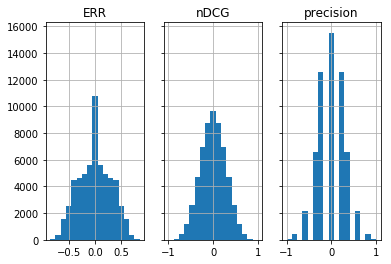

In [23]:
f, axs = plt.subplots(1, len(offline_measures), sharey=True)
a = 0
for c in offline_measures.keys():
    f = df[c].hist(bins=17, ax=axs[a])
    axs[a].set_title(c)
    a += 1

In the following plot, the percentage of "wins", "losses" and "ties" for each offline measures are represented. Again, having used the whole dataset, the number of wins and losses is identical. Is nevertheless interesting to notice that Precision allows the number of ties to be higher, since it just considers the relevance labels (also 'HR' and 'R' are both considered relevant) and not the ranking, hence giving the same score to much more pairs of rankings compared to other two measures.


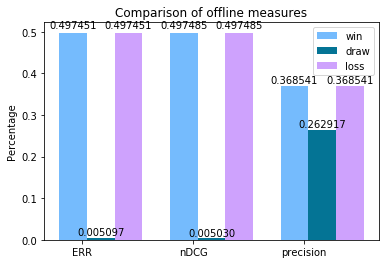

In [24]:
N = 3
wins_for_plot = [percent_of_wins[m] for m in offline_measures]
ties_for_plot = [percent_of_ties[m] for m in offline_measures]
losses_for_plot = np.ones(3) - wins_for_plot - ties_for_plot


ind = np.arange(N)  # the x locations for the groups
width = 0.25       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, wins_for_plot, width, color='xkcd:sky blue')
rects2 = ax.bar(ind + width, ties_for_plot, width, color='xkcd:sea blue')
rects3 = ax.bar(ind + width + width, losses_for_plot, width, color='xkcd:lilac')

# add some text for labels, title and axes ticks
ax.set_ylabel('Percentage')
ax.set_title('Comparison of offline measures')
ax.set_xticks(ind + width / 3)
ax.set_xticklabels(offline_measures)

ax.legend((rects1[0], rects2[0], rects3[0]), ('win', 'draw', 'loss'))

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%f' % height,
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.show()

For what concerns the online evaluation of the algorithms, we implemented Team-Draft and Probabilistic Interleaving (since we did it before the change in the homework question) algorithms to combine a pair of rankings and two click models to simulate user interactions.

After training on the provided dataset, we obtain the following values for the parameters of the click models:

**Random Click Model**: this model is defined assigning the same probability to each document in the ranking. The probability is obtained averaging the total number of clicks over the number of documents. The value we expected to find was around 10%, since for each query ten documents are shown, hence the obtained value of 13% is acceptable.

In [25]:
print("p = ", RCM.p)

p =  0.1327909593922911


**Position Based Model**: to train this model we used a Expectation-Maximization algorithm which updates both the attractivness parameters $\alpha_{uq}$ and the examination parameters $\gamma_r$. Since there is an attractivness parameter for each pair query-document in the Yandex dataset and we only have relevance labels in our toy dataset, the attractivnesses are discarded after training. Instead we used the following values that seem to mirror a reasonable behaviour(non-relevant documents are almost not attractive at all, while highly relevant ones are very attractive):

In [26]:
print("alpha = ", PBM.alphadict)

alpha =  {'HR': 0.95, 'R': 0.5, 'N': 0.05}


For what concerns the examination parameters, after 10 iterations we obtain the values shown in the table below. Higher ranked documents correctly have a higher probability of being examined and the probability deacreases with the ranking.

In [27]:
gamma_vals = {'rank,  gamma values': PBM.gammas}
gamma_pd = pd.DataFrame(gamma_vals, index = range(1, 11))
print(gamma_pd)

    rank,  gamma values
1              0.963108
2              0.756393
3              0.653190
4              0.561801
5              0.490169
6              0.434835
7              0.405459
8              0.372457
9              0.351930
10             0.364105


Finally, the following plots compare offline and online evaluation metrics.  The first set of plots uses the whole dataset. The second one uses instead a biased dataset, where only the pairs where the algorithm E gets a higher offline measure (for each of the considered measures) are used. The plots display the estimated distribution on the top and on the side, and the joint distribution in the main plot. All the plots have the $\Delta$ measures for each offline measure on the x axis and the percentage of wins on the y axis. Furthermore, the Pearson correlation coefficient and the p-value for testing non-correlation are displayed. It is interesting to notice that the Random Click Model seems not to be correlated at all to the offline measures, while the Position Based Model agrees on both the biased and unbiased datasets.

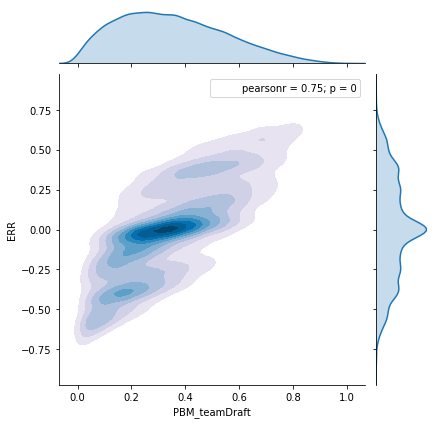

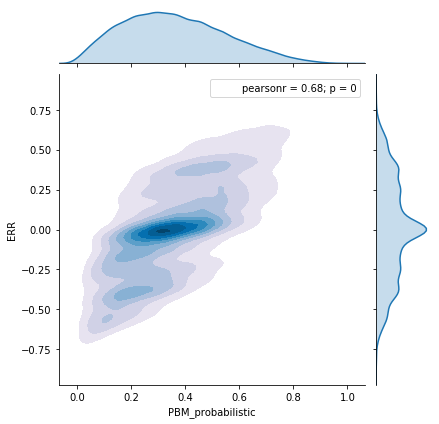

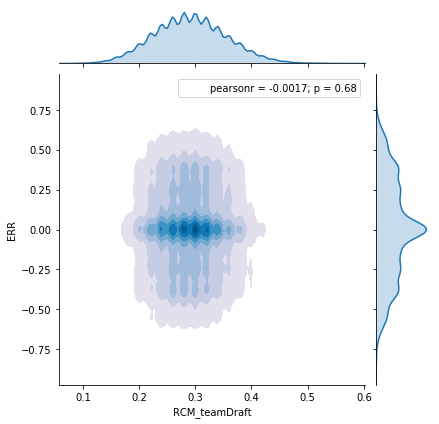

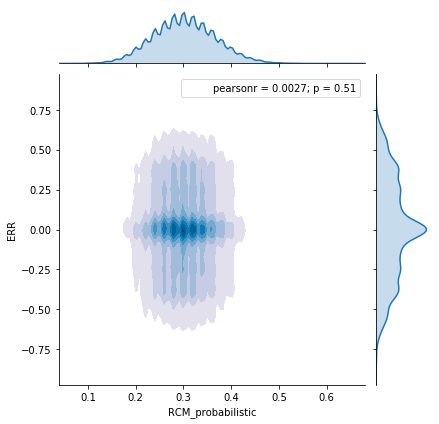

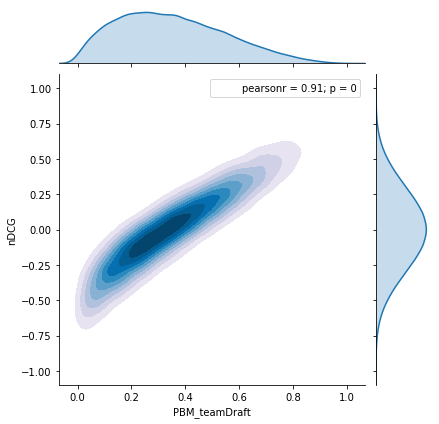

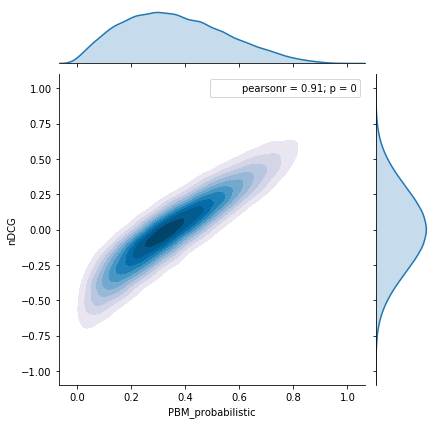

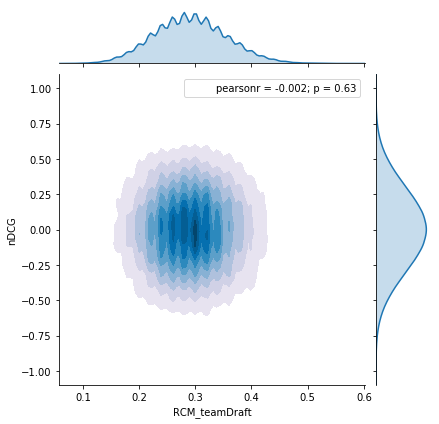

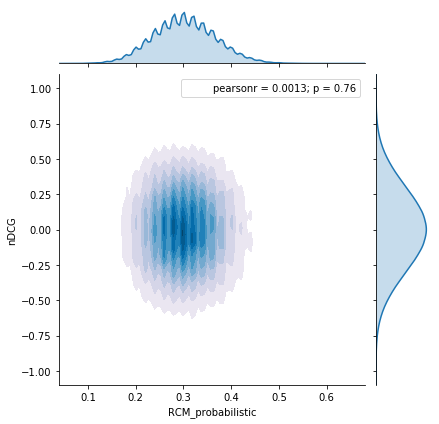

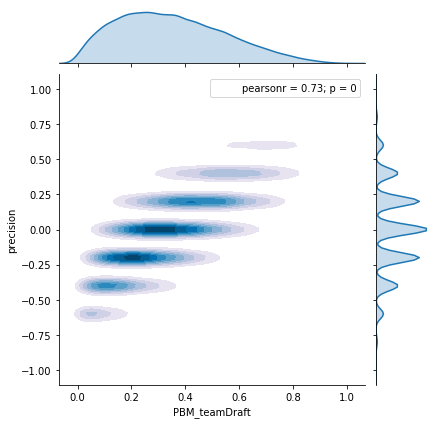

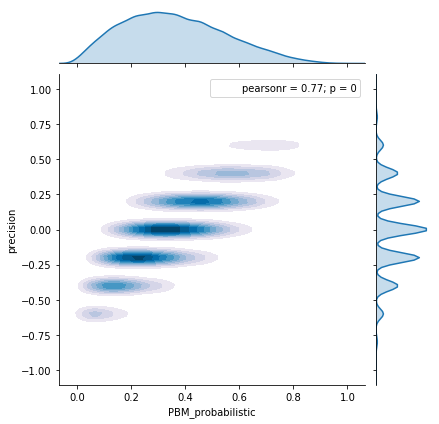

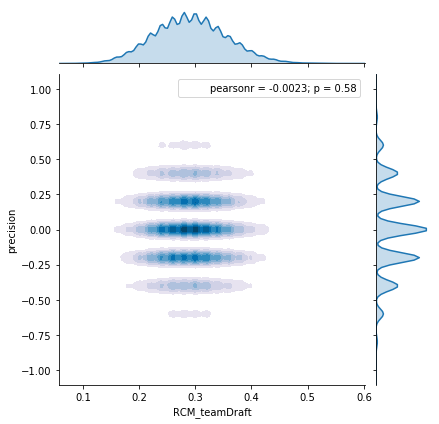

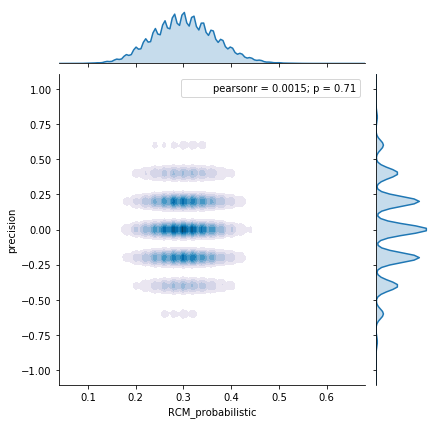

In [28]:
online = [m + '_' + i for m in online_measures.keys() for i in interleavers.keys()]

def kde_plots(data, online, offline):
    
    for off in offline:        
        for on in online:
            g = sns.jointplot(x=on, y=off, data=data, kind="kde", shade = True, cmap = "PuBu")
            g.ax_joint.collections[0].set_alpha(0)


kde_plots(df, online, offline_measures.keys())

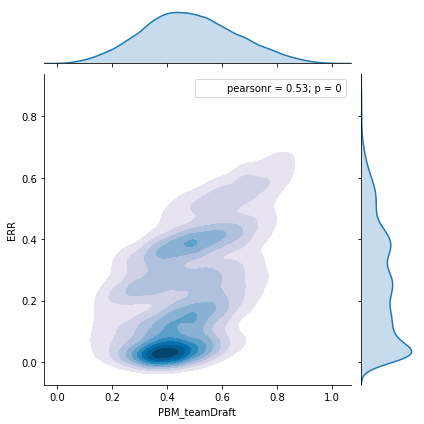

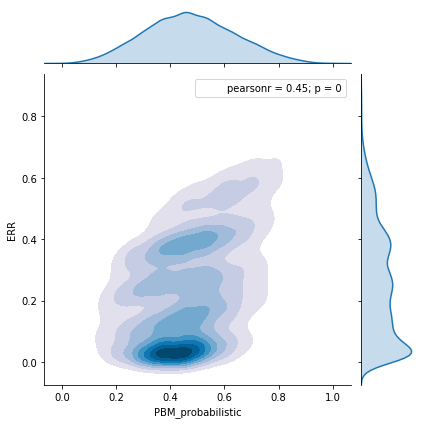

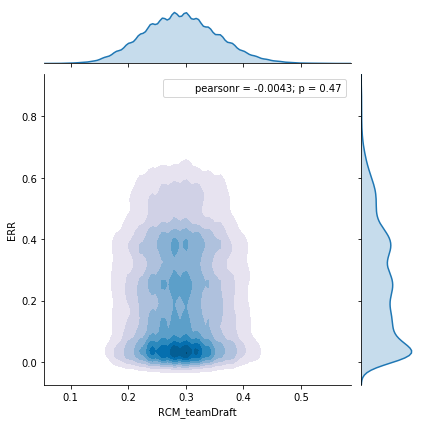

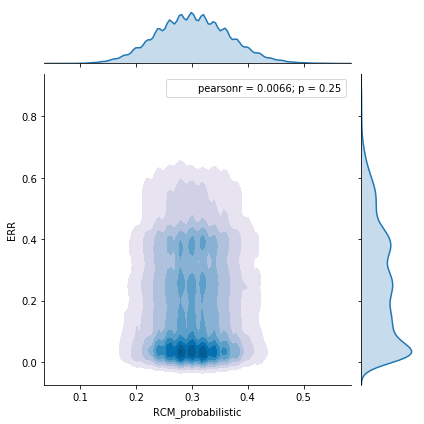

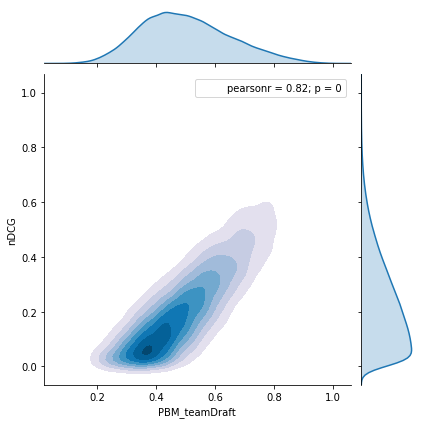

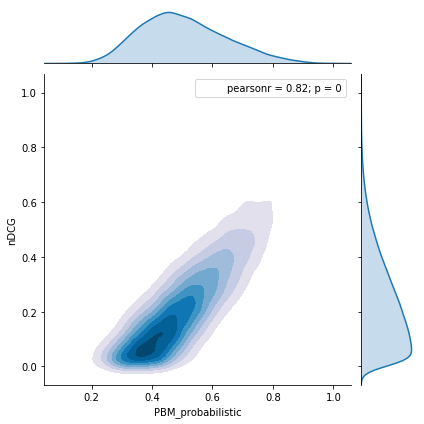

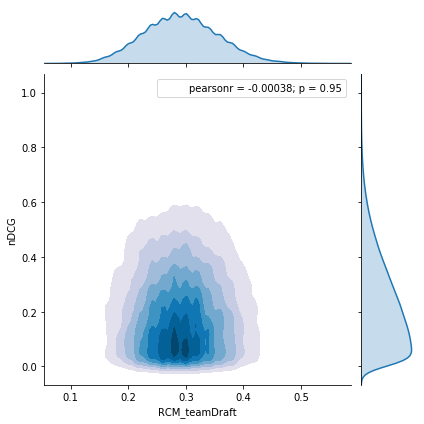

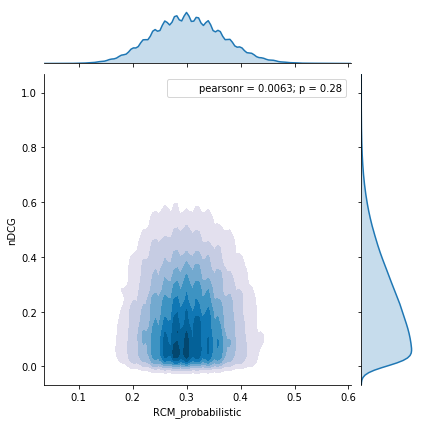

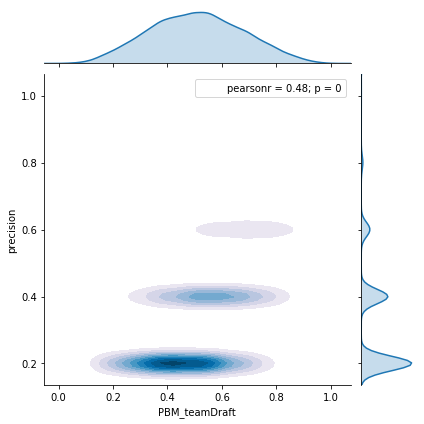

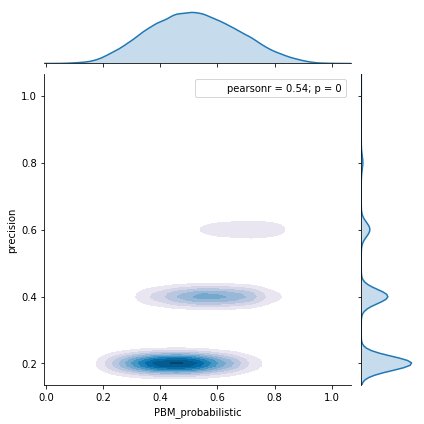

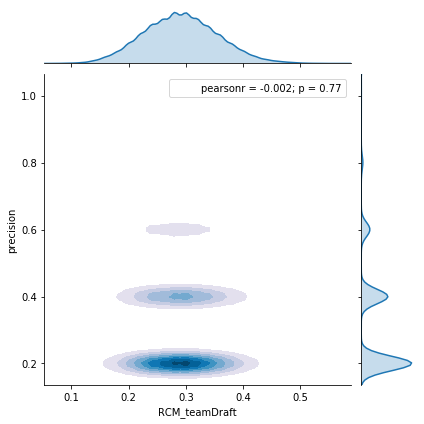

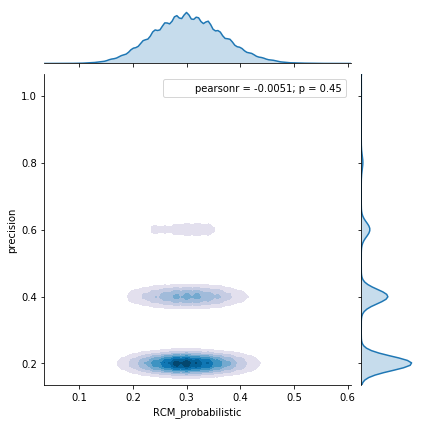

In [29]:
x, y = 0, 0
for off in offline_measures.keys():
    x = 0
    for on in online:
        tmp = df[df[off] > 0]
        g = sns.jointplot(x=on, y=off, data=tmp, kind="kde", shade = True, cmap = "PuBu")
        g.ax_joint.collections[0].set_alpha(0)
        x +=1
    y +=1


Using the PBM, all the three offline measures seems correlated with it.

**nDCG** seems the most correlated online measure.

Conversely, **ERR** and **Precision** seem to be less correlated.

Since Precision doesn't take into account the position of the documents, two datapoint with similar precision value may have very different PBM values (e.g. one has all the relevant documents at the beginning while the other has them at the end).

Instead, the difference between ERR and PBM might be explained considering that when computing the probability of a position to be examinated, ERR takes into account also the documents seen before (i.e. the probability of clicking on a document is proportional to the probability of not having clicked on the documents before, which in turn depends on how relevant they were). Conversely, in PBM the probability of examining a position is a parameter fixed after the training. As a result, when a lot of relevant documents are present, PBM is likely to assign an higher value (since ERR would heavily decrease the probability of examine the last documents).
This effect can be seen in the previous plots: when the difference in the ERR is very high, PBM values are high too while PBM variance is at its minimum; conversely, lower the ERR difference is, higher is the PBM variance. Indeed, ERR seems to be the offline measure which scores the lower correlation value against PBM.
Moreover, many datapoints fall in the low ERR difference region. When considering the biased dataset, many points will still belong to this high variance and noisy region, leading to a poorer result.



One possible way to estimate the result of an interleaving experiment, as described in "Large-Scale Validation and Analysis of Interleaved Search Evaluation" by O.Chapelle, is based on the following score:

$\Delta = \frac{win(E) + \frac{1}{2} ties(E, P)}{wins(E) + wins(P) + ties(E, P)} - \frac{1}{2}$

If the values is positive, then the algorithm E is considered to perform better. In step 6, we computed this value for N = 5 experiments, using both the biased (only w.r.t. Precision) and unbiased dataset and all the combinations of interleaving algorithms and click models, obtaining the following scores. The values are positive for the unbiased dataset, though they are very close to zero: indeed, the experiments are not deterministic but E is equally likely to get clicks as P since the dataset is simmetrical. Therefore, on the long run, this value will be on average 0. Instead, using the biased dataset, the score for the PBM model increases significanly, showing that the offline measure and the online agree to some extent, while the random click model still doesn't give significant results.
This is because the Random Click Model assigns equal probabilities to click on documents independently on their rank, while ERR and nDCG values are dependant on the sorting in the ranking. On the other side, even Precision does not correlate with RCM, since its value depends on the presence of relevant document in the ranking, while in RCM the winning chance is totally random.

In [31]:
print("Unbiased dataset:")
print("RCM with teamDraftInterleaving: ", delta_results['teamDraft']['RCM'])
print("PBM with teamDraftInterleaving: ", delta_results['teamDraft']['PBM'])
print("\n")
print('Using Biased Dataset (w.r.t. Precision):')
print("RCM with teamDraftInterleaving: ", delta_results_biased['teamDraft']['RCM'])
print("PBM with teamDraftInterleaving: ", delta_results_biased['teamDraft']['PBM'])

Unbiased dataset:
RCM with teamDraftInterleaving:  -0.00018120543955020275
PBM with teamDraftInterleaving:  0.0005131331605954359


Using Biased Dataset (w.r.t. Precision):
RCM with teamDraftInterleaving:  -0.00015623564010660562
PBM with teamDraftInterleaving:  0.1537037037037037


On the other hand, in order to determine statistically whether the online and the offline evaluations agree, we perform a Binomial Proportion Test: for a biased dataset and an online measure we run experiments over all the N_EXP in the dataset. An experiment is considered a success when it is a victory for E. We expected the win ratio to be grater than 0.5 if the offline and online measures.
For all the offline measures, the Random Click Model doesn't provide a statistically significant evidence for concluding (indeed, the ratio is very low). On the other hand, the Position Based Model gives results that agree with the offline measures.


In [32]:

online = [m + '_' + i for m in online_measures.keys() for i in interleavers.keys()]

for off in offline_measures.keys():
    print("offline measure: ", off)
    
    for on in online:
        print('\t' + on + ':')
        print('\t\tRatio:', df[(df[off] > 0) & (df[on] >= 0.5)][on].sum()/df[df[off] > 0][on].sum())
        
        print('\t\tWins:', round(df[(df[off] > 0) & (df[on] >= 0.5)][on].sum()*N_EXP), 'out of', round(df[df[off] > 0][on].sum()*N_EXP), 'Experiments')
        
        print('\t\tBinomial Test:', binom_test(round(df[(df[off] > 0) & (df[on] >= 0.5)][on].sum() * N_EXP), round(df[df[off] > 0][on].sum() * N_EXP), 0.5, alternative='less'))
    
    

offline measure:  ERR
	PBM_teamDraft:
		Ratio: 0.6060304163381595
		Wins: 428855 out of 707646 Experiments
		Binomial Test: 1.0
	PBM_probabilistic:
		Ratio: 0.5901882269071785
		Wins: 410627 out of 695756 Experiments
		Binomial Test: 1.0
	RCM_teamDraft:
		Ratio: 0.0027376351313505125
		Wins: 1173 out of 428472 Experiments
		Binomial Test: 0.0
	RCM_probabilistic:
		Ratio: 0.004655476713611775
		Wins: 2068 out of 444208 Experiments
		Binomial Test: 0.0
offline measure:  nDCG
	PBM_teamDraft:
		Ratio: 0.6174302942844465
		Wins: 455240 out of 737314 Experiments
		Binomial Test: 1.0
	PBM_probabilistic:
		Ratio: 0.6123193201494931
		Wins: 453360 out of 740398 Experiments
		Binomial Test: 1.0
	RCM_teamDraft:
		Ratio: 0.002787529595633292
		Wins: 1195 out of 428695 Experiments
		Binomial Test: 0.0
	RCM_probabilistic:
		Ratio: 0.0045504694571410565
		Wins: 2021 out of 444130 Experiments
		Binomial Test: 0.0
offline measure:  precision
	PBM_teamDraft:
		Ratio: 0.674307870089924
		Wins: 372870 out